In [4]:
import glob
import os
import subprocess
import pickle as cPickle
import ast
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import numpy as np
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pandas as pd
import seaborn as sns
import re

# Setup

In [5]:
#path depending on timebin
pca_res_path="./c-transfer"
pcmci_res_path="./output"
f1_scores_path="./output_f1-scores_lag1/time"
model_names=['ACCESS-CM2', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC-ES2L',
             'MPI-ESM1-2-HR', 'UKESM1-0-LL']


In [6]:
related_models=[] #wie am besten machen, falls überhaupt so? Hier mal als Äquivalenzklassen
related_models.append((0, 6, 10))
related_models.append((1,))
related_models.append((2,))
related_models.append((3,))
related_models.append((4,))
related_models.append((5,))
related_models.append((0, 6, 10))
related_models.append((7,))
related_models.append((8,))
related_models.append((9,))
related_models.append((0, 6, 10))

In [7]:
f1Scores={}
for file in os.listdir(f1_scores_path):
    match = re.search(r"time=([0-9.]+)", file)
    if match:
        time_value = float(match.group(1))
    else:
        print("no time found")
    f1_scores_single_path=os.path.join(f1_scores_path, file)
    f1_scores_single=pickle.load(open(f1_scores_single_path,"rb"))
    pc_alpha=f1_scores_single['pc_alpha']
    n_kept_comp=f1_scores_single['n_kept_comp']
    f1Scores[(pc_alpha, n_kept_comp, time_value)]=f1_scores_single['f1Scores']    

In [8]:
f1Scores_={} #f1Scores sortiert bzw. die einträge der keys sortiert nach alpha_value
for key in f1Scores:
    scores=f1Scores[key]
    tempList={}
    for element in scores:
        for key2 in element:
            tempList[key2]=element[key2]
    sorted_dict = dict(sorted(tempList.items()))
    f1Scores_[key]=sorted_dict
    

## Auswertung

In [9]:
avg_f1_scores_models={} #avg F1-Score for each refModel F1-Matrix
for key in f1Scores_:
    scores=f1Scores_[key]
    avg_f1_scores_models.setdefault(key, {})
    for key2 in scores:
        avg_f1_scores_models[key][key2]=np.nanmean(scores[key2], axis=(2, 3)) #also avg f1 score für key1=pc_alpha und key2=refDataSet

In [10]:
#metric1 for all refDatasets. Returns average f1-score-metric1-distance for all refDatasets
def metric1(f1scores): #f14d matrix
    result=[]
    for i,refDataset in enumerate(f1scores):
        scores=f1scores[i]
        min_scores=[]
        max_scores=[]
        for element in scores:
            arr=np.array(element)
            min_scores.append(np.nanmin(arr))
            max_scores.append(np.nanmax(arr))
        result.append(np.mean(np.subtract(max_scores, min_scores)))
    return result

In [11]:
def metric2_(key, f1scores, relModelsTuple, refModelIndex, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
    for i, modelIndex in enumerate(relModelsTuple):
        for j, model in enumerate(model_names):
            if j not in relModelsTuple:
                val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                avgF1Distance[i][j]=val
                                        
    return avgF1Distance, np.nanmean(avgF1Distance)
        
    
    

In [12]:
def metric2(key, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1DistanceFinal=[]
    for refModelIndex, model in enumerate(model_names):
        relModelsTuple=related_models[refModelIndex]
        avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
        for i, modelIndex in enumerate(relModelsTuple):
            for j, model in enumerate(model_names):
                if j not in relModelsTuple:
                    val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                    avgF1Distance[i][j]=val
        avgF1DistanceFinal.append(np.nanmean(avgF1Distance))
    #print(key, np.nanmean(np.array(avgF1DistanceFinal)))
    return np.array(avgF1DistanceFinal), np.nanmean(np.array(avgF1DistanceFinal))
        
    
    

In [13]:
def plot_metric2_div_metric1(key):
    # Gleichmäßig verteilte x-Werte erstellen
    values=metric2_div_metric1[key]
    x_values, y_values = zip(*values)
    x_values=list(x_values)
    
    for element in x_values:
        element=np.log10(element)
        
    y_values=list(y_values)
    x_uniform = np.linspace(min(x_values), max(x_values), len(x_values))
    labels=x_values

    # Plot erstellen
    plt.plot(x_uniform, y_values, marker='o', linestyle='-')

    # Labels hinzufügen
    for i, txt in enumerate(labels):
        plt.annotate(txt, (x_uniform[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
        
    plotTitle='Nr. of components: ' + str(key[1]) + ', pc_alpha: ' + str(key[0])
    plt.title(plotTitle)
    plt.ylabel('F1-Score')
    plt.figtext(0, 0, 'The resulting M2/M1 for N components, specific pc_alpha (see title) and different alpha_values vizualized')

    plt.ylim(0, 3)
    
    # Plot anzeigen
    plt.show()

In [14]:
metric1Mins={} #Mins for the metric1 mean values per (alphaValue, n_kept_comp)
for key in f1Scores_:
    metric1values=[]
    f1_score_single=f1Scores_[key] 
    for key2 in f1_score_single:
        metric1values.append(   (key2, np.mean((metric1(f1_score_single[key2]))))   )
        if key[1]==100 and key2==0.0005:
            metric1_vs_pcAlpha.append((key[0], np.mean((metric1(f1_score_single[key2])))))
    metric1Mins[key]=min(metric1values, key = lambda t: t[1])

        


In [15]:
metric2Maxs={}
for key in f1Scores_:
    metric2values=[]
    f1_score_single=f1Scores_[key]
    for key2 in f1_score_single:
        #metric2values.append((key2, metric2_(key, None, related_models[0], 6, key2)[1]))
        metric2values.append((key2, metric2(key, key2)[1]))
        if key[1]==100 and key2==0.0005:
            metric2_vs_pcAlpha.append((key[0], metric2(key, key2)[1]))
    metric2Maxs[key]=max(metric2values, key = lambda t: t[1])

In [16]:
metric2_div_metric1_maxs={}
metric2_div_metric1={}
for key in f1Scores_:
    metric2divmetric1values=[]
    f1_score_single=f1Scores_[key]
    metric2_div_metric1.setdefault(key, [])
    for key2 in f1_score_single:
        m1=np.mean(metric1(f1_score_single[key2]))
        #m2=metric2_(key, None, related_models[0], 6, key2)[1]
        m2=metric2(key, key2)[1]
        metric2divmetric1values.append((key2, m2/m1, m2, m1))
        metric2_div_metric1[key].append((key2, m2/m1))
    metric2_div_metric1_maxs[key]=max(metric2divmetric1values, key = lambda t: t[1])

/tmp/ipykernel_2383/1632574356.py:11: RuntimeWarning: invalid value encountered in double_scalars
  metric2divmetric1values.append((key2, m2/m1, m2, m1))
/tmp/ipykernel_2383/1632574356.py:12: RuntimeWarning: invalid value encountered in double_scalars
  metric2_div_metric1[key].append((key2, m2/m1))


In [17]:
metric2_div_metric1_maxs_2={} #(comps, pc_alpha, alpha_value): F1-Score  wobei alpha_value für den max erreichten F1-Score gegeben ist
for key in metric2_div_metric1_maxs:
    pc_alpha=key[0]
    comps=key[1]
    time=key[2]
    alpha_value=metric2_div_metric1_maxs[key][0]
    metric2_div_metric1_maxs_2[(comps,pc_alpha,alpha_value,time)]=metric2_div_metric1_maxs[key]

In [18]:
sorted_dict_komps = dict(sorted(metric2_div_metric1_maxs_2.items(), key=lambda x: x[0][0])) #sortiert nach comps, dann pc_alpha

In [20]:
temp = sorted(sorted_dict_komps.items(), key=lambda x: x[1][1])

In [21]:
sorted_data = sorted(temp, key=lambda x: x[0][3])
x_values = [entry[0][3] for entry in sorted_data]
y_values = [entry[1][1] for entry in sorted_data]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-')
plt.xlabel('number of days from start')
plt.ylabel('M2/M1')
plt.grid(True)
plt.title('number of days from start vs M2/M1)
#plt.savefig('./BilderBA/timeanalysis_moreData_lag1_100comp_pcalpha-32.pdf')

plt.show()

SyntaxError: unterminated string literal (detected at line 10) (3670712873.py, line 10)

In [20]:
temp = sorted(sorted_dict_komps.items(), key=lambda x: x[1][1])
for element in temp:
    if element[0][0]==100:
        print(element)


((100, 0.275, 0.001), (0.001, 2.303343694930609, 0.05410502773225762, 0.02348977612474269))
((100, 0.3, 0.001), (0.001, 2.320138999398189, 0.053993861245266776, 0.023271821756917156))
((100, 0.25, 0.0005), (0.0005, 2.346943941252971, 0.05790975746323719, 0.02467453800039242))
((100, 0.225, 0.001), (0.001, 2.471588092290716, 0.054708693758625755, 0.022135036954284995))
((100, 0.2, 0.001), (0.001, 2.5458154855709996, 0.054678947096039814, 0.02147796939956782))
((100, 0.125, 0.001), (0.001, 2.5605456939850963, 0.055573191581475646, 0.02170365157396762))
((100, 0.175, 0.005), (0.005, 2.6025748925084966, 0.04315122906151501, 0.016580206466190725))
((100, 0.1, 0.0005), (0.0005, 2.673630480775976, 0.05957853041620689, 0.022283756429540415))
((100, 0.15, 0.001), (0.001, 2.6904224460408135, 0.05517771070299691, 0.02050893932445279))
((100, 0.0225, 0.005), (0.005, 2.693234952784037, 0.04744538407373761, 0.017616503909060225))
((100, 0.05, 0.0001), (0.0001, 2.7458742934391442, 0.06625095743329802

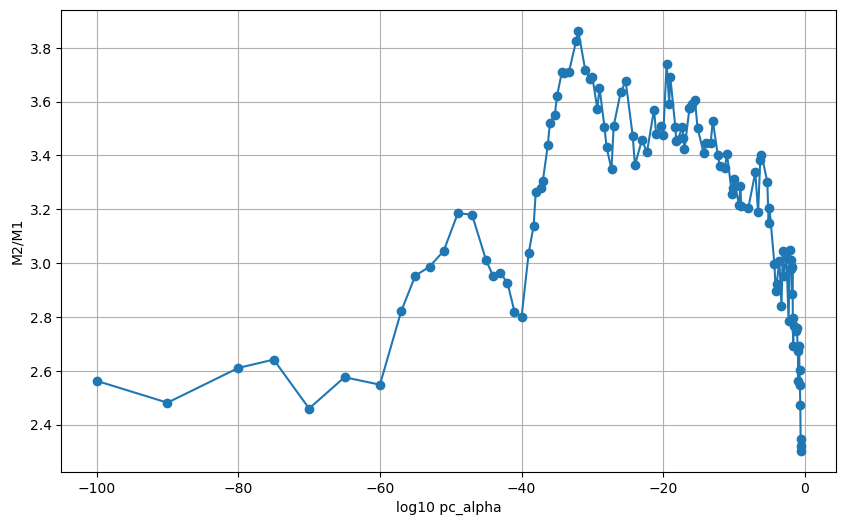

In [22]:
filtered_data100 = [item for item in temp if item[0][0] == 100]
sorted_data100 = sorted(filtered_data100, key=lambda x: x[0][1])  # Sortieren nach dem zweiten Schlüsselwert
data = sorted_data100

x_values = [entry[0][1] for entry in data]  # Zweiter Eintrag des ersten Elements
y_values = [entry[1][1] for entry in data]  # Zweiter Eintrag des zweiten Elements

# 10er-Logarithmus auf die x-Werte anwenden
x_values_log10 = np.log10(x_values)

plt.figure(figsize=(10, 6))
plt.plot(x_values_log10, y_values, marker='o', linestyle='-')
plt.xlabel('log10 pc_alpha')
plt.ylabel('M2/M1')
#plt.title('PCMCI on 100 components. For a given pc_alpha, the best performing mci_alpha from a given list of values was chosen')
plt.grid(True)
plt.savefig('./BilderBA/'+'+pctests100comps'+'.pdf',dpi=600)

plt.show()

In [ ]:
#dict(sorted(metric2_div_metric1_maxs_2.items(), key=lambda item: item[1][1], reverse=True))

In [51]:
def scatter_plot_2(data,model_nr,title,name,save_name,vmin,vmax,nr_intervals,label):
    size_s=40
    nr_models=len(data[:,0,0,0])
    average=0
    n_ensembles=nr_intervals
    all_values = []  # Hier werden alle Werte gesammelt

    for i in range(0,nr_models):
#         print i                                                                                                                                                                                                                                                           
#         if name[i]==name[model_nr]:                                                                                                                                                                                                                                       
#             print name[i]                                                                                                                                                                                                                                                 
        if name[i] in ['era', 'NCEP']: #2*datashape 3
            plt.scatter(np.ones((nr_intervals**2))*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)     #da auch r zu k
            else:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        else:
#             print name[i],data[model_nr,i,:,:].flatten()[0:n_ensembles]                                                                                                                                                                                                   
            plt.scatter(np.ones(4*4)*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)              #da x color ändern
            else:
                average+=np.nanmean(data[model_nr,i,:,:],axis=(0,1))
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        all_values.extend(data[model_nr, i, :, :].flatten())

    min_value = np.nanmin(all_values)
    max_value = np.nanmax(all_values)

    
    
    #### REVISE
    average/=(nr_models-1) #    average/=double(nr_models-1)
    print('average', average)
    plt.plot(np.linspace(-0.5,nr_models+1,100)-0.25,np.ones((100))*average,color='gray',linestyle='--',linewidth=2)
    plt.xticks(np.arange(0,nr_models),name[:],rotation=90,size=12)
    plt.ylabel(label,size=16,fontweight='bold')
    plt.xlim(-0.5,nr_models-0.5)
    #plt.ylim(vmin,vmax)
    plt.ylim(max(0, min_value-0.1), min(1, max_value+0.1))
    #plt.title(title,fontweight='bold',size=12)
    plt.title('Reference: ' + model_names[model_nr],fontweight='bold',size=12)
    #plt.savefig('./images/gridSearch/'+title+'.png',dpi=600)
    plt.show()
    plt.close()

In [20]:
metric2_div_metric1=dict(sorted(metric2_div_metric1.items(), key=lambda x: x[0][1]))

In [21]:
#-----for each nr. components, print the pc_alpha which achieves the highest F1-Score-----


temp={}
#pc_lpha, comps = zip((list(metric2_div_metric1_maxs.keys())))
temp2=list(metric2_div_metric1_maxs.keys())
pc_alpha, comps = zip(*temp2)
pc_alpha=list(set(pc_alpha))
comps=list(set(comps))
for key in comps:
    temp.setdefault(key, [])
    
for key in metric2_div_metric1_maxs:
    temp[key[1]].append((key[0], metric2_div_metric1_maxs[key][1]))
    
temp=dict(sorted(temp.items()))



In [ ]:
filter_pcAlpha_pdDf=0.2
filter_mciAlpha_pdDf=1e-5
filter_nrComponents_pdDf=100

In [ ]:
#Pandas Dataframe for Metric1



pandasDfList=[]
for key1 in f1Scores_.keys():
    for key2 in f1Scores_[key1].keys():
        if key2 == filter_mciAlpha_pdDf:
#            print(np.nanmean(metric1(f1Scores_[key1][key2])), key1, key2)
            pandasDfList.append((np.nanmean(metric1(f1Scores_[key1][key2])), key1, key2))




df = pd.DataFrame(pandasDfList, columns=['Metric1', 'Nr. components', 'pc_alpha'])

# Extrahiere Werte für 'mci_alpha' aus dem zweiten Element des Tupels
df['pc_alpha'] = df['Nr. components'].apply(lambda x: x[0])
df['Nr. components'] = df['Nr. components'].apply(lambda x: x[1])
_,_,mci_alpha = zip(*pandasDfList)
df['mci_alpha']=mci_alpha


df_sorted = df.sort_values(by='Nr. components', ascending=True)

df_filtered_m1vscomps = df_sorted.loc[df_sorted['pc_alpha'] == filter_pcAlpha_pdDf]

df_filtered_m1vspcalpha = df.sort_values(by='pc_alpha', ascending=True)
df_filtered_m1vspcalpha = df.loc[df['Nr. components'] == filter_nrComponents_pdDf]


#---now for all mci_alpha---
pandasDfList2=[]
for key1 in f1Scores_.keys():
    for key2 in f1Scores_[key1].keys():
        pandasDfList2.append((np.nanmean(metric1(f1Scores_[key1][key2])), key1, key2))
        
df2data=[]
for element in pandasDfList2:
    df2data.append((element[0], element[1][1], element[1][0], np.log10(element[2])))
    
df2 = pd.DataFrame(df2data, columns=['Metric1', 'Nr. components', 'pc_alpha', 'log10(mci_alpha)'])

df_filtered_m1vsmcialpha_temp = df2.loc[df2['Nr. components'] == filter_nrComponents_pdDf]
df_filtered_m1vsmcialpha = df_filtered_m1vsmcialpha_temp.loc[df_filtered_m1vsmcialpha_temp['pc_alpha'] == filter_pcAlpha_pdDf]














In [ ]:
df_filtered_m1vsmcialpha

In [ ]:
pandasDfList3=[]
relatedModels=related_models[0]
refModelIndex=6
for key1 in f1Scores_.keys():
    for key2 in f1Scores_[key1].keys():
#        print(metric2_(key1, None, related_models[0], 6, key2)[1], key1, key2)
        pandasDfList3.append((metric2_(key1, None, relatedModels, refModelIndex, key2)[1], key1[1], key1[0], key2))
    
df3 = pd.DataFrame(pandasDfList3, columns=['Metric2', 'Nr. components', 'pc_alpha', 'mci_alpha'])



df3_filtered_m2vsnrcomponents=(df3.loc[df2['pc_alpha'] == filter_pcAlpha_pdDf]).loc[df3['mci_alpha'] == filter_mciAlpha_pdDf]
df3_filtered_m2vsnrcomponents = df3_filtered_m2vsnrcomponents.sort_values(by='Nr. components', ascending=True)


df3_filtered_m2vspcalpha=(df3.loc[df2['Nr. components'] == filter_nrComponents_pdDf]).loc[df3['mci_alpha'] == filter_mciAlpha_pdDf]
df3_filtered_m2vspcalpha = df3_filtered_m2vspcalpha.sort_values(by='pc_alpha', ascending=True)


df3_filtered_m2vsmcialpha=(df3.loc[df2['Nr. components'] == filter_nrComponents_pdDf]).loc[df3['pc_alpha'] == filter_pcAlpha_pdDf]
df3_filtered_m2vsmcialpha = df3_filtered_m2vsmcialpha.sort_values(by='mci_alpha', ascending=True)







In [ ]:
df3_filtered_m2vsnrcomponents

In [ ]:
df3_filtered_m2vspcalpha

In [ ]:
df3_filtered_m2vsmcialpha

In [ ]:
import math
def plotMetric2DivMetric1_log(key):
    m2divm1_values=[]
    mci_alpha_values=[]
    for element in metric2_div_metric1[key]:
        m2divm1_values.append(((element[1])))
        mci_alpha_values.append(math.log10(element[0]))
    plt.plot(mci_alpha_values, m2divm1_values, marker='o', linestyle='-')
    plt.xlabel('log10(mci_alpha)')
    plt.ylabel('Metric2 / Metric1')
    plt.title("Number of components = " + str(key[1]) + " and pc_alpha = " + str(key[0]))
    plt.grid(True)
    plt.savefig("./images/gridSearch/" + "Number of components = " + str(key[1]) + " and pc_alpha = " + str(key[0]) + " Log10.pdf")
    plt.show()

              
plotMetric2DivMetric1_log((0.025, 50))

## Bilderzeugs

In [52]:
temp

[((3, 0.025, 1e-06),
  (1e-06, 0.6979472457746632, 0.17210575712744464, 0.24658848955900903)),
 ((5, 0.1, 0.01),
  (0.01, 0.7137888887257959, 0.09987575745960911, 0.13992338496316475)),
 ((5, 0.3, 0.0001),
  (0.0001, 0.7185663384821996, 0.12048443153936797, 0.16767335886323684)),
 ((5, 0.175, 7e-07),
  (7e-07, 0.7198226917283925, 0.13920636889304835, 0.19338980347895793)),
 ((5, 0.025, 5e-08),
  (5e-08, 0.7208711826542743, 0.16706659365490698, 0.2317565158309722)),
 ((5, 0.25, 0.0001),
  (0.0001, 0.7220764224198596, 0.11884884184797233, 0.1645931623825633)),
 ((5, 0.275, 0.0001),
  (0.0001, 0.7258520477018973, 0.11771543316718708, 0.162175519845791)),
 ((5, 0.2, 0.01),
  (0.01, 0.7303970396862763, 0.10117687499353294, 0.13852311755944535)),
 ((5, 0.125, 0.005),
  (0.005, 0.7605296542800305, 0.10771543631505841, 0.14163213190816237)),
 ((5, 0.225, 0.01),
  (0.01, 0.7647336738503856, 0.10438888965190275, 0.13650358709367577)),
 ((5, 0.15, 0.005),
  (0.005, 0.7962338674998124, 0.107230661

In [20]:
plot1={}
for element in temp:
    plot1[element[0][0]]=(0,0,0)

In [21]:
for element in temp:
    ncomp=element[0][0]
    pcalpha=element[0][1]
    mcialpha=element[0][2]
    m2divm1=round(element[1][1], 5)
    if pcalpha < 0.05:
        continue
    if plot1[ncomp][2]<=m2divm1:
        plot1[ncomp]=(pcalpha, mcialpha, m2divm1)

In [22]:
temp1 = []
for key in plot1:
    value = plot1[key]
    temp1.append((str(int(key)), value[0], value[1], value[2]))  # Umwandlung von key in Integer und dann in String
df1 = pd.DataFrame(temp1, columns=['number components', 'pc_alpha', 'mci_alpha', 'M2/M1'])

# DataFrame als PDF ohne Zeilennummern speichern
plt.figure(figsize=(10, 8))
plt.table(cellText=df1.values,
          colLabels=df1.columns,
          loc='center')
plt.axis('off')  # Achsen ausschalten
plt.savefig('./BilderBA/df1.pdf', bbox_inches='tight', pad_inches=0.05)
plt.close()

df1

,number components,pc_alpha,mci_alpha,M2/M1
0,3,0.200,1.000000e-07,1.35902
1,5,0.075,3.000000e-07,0.82918
2,10,0.050,1.000000e-07,0.97288
3,15,0.100,5.000000e-04,1.10825
4,20,0.075,1.000000e-03,1.24058
5,25,0.075,5.000000e-03,1.48381
6,30,0.075,1.000000e-02,1.68998
7,40,0.075,1.000000e-03,1.93500
8,50,0.050,1.000000e-02,1.99044
9,65,0.050,3.000000e-05,2.33773


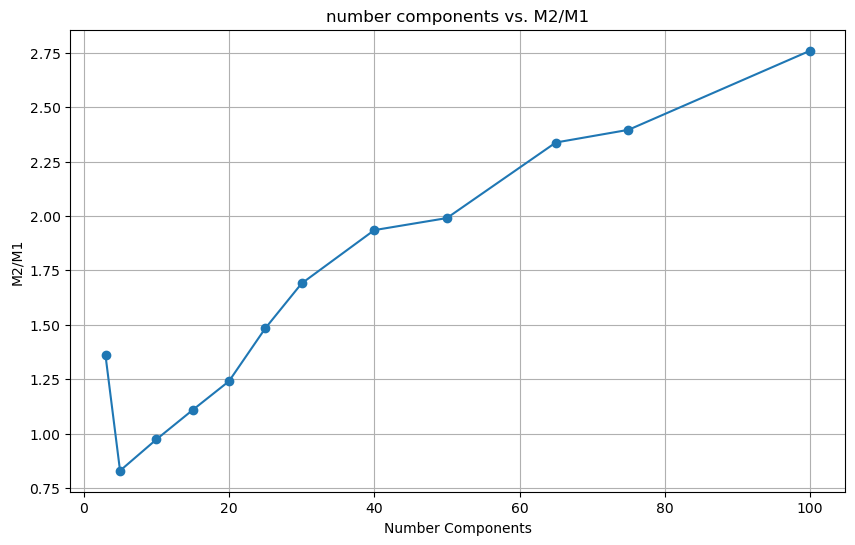

In [25]:
# x- und y-Werte aus dem DataFrame extrahieren
x = df1['number components'].astype(int)  # 'number components' in Integer umwandeln
y = df1['M2/M1']

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('Number Components')
plt.ylabel('M2/M1')
plt.title('number components vs. M2/M1')
plt.grid(True)

# Plot als PDF speichern
plt.savefig('./BilderBA/df1Plot.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

In [26]:
plot2={}
for element in temp:
    if element[0][1]<0.05:
        continue
    plot2[element[0][1]]=(0,0,0)



In [27]:
for element in temp:
    ncomp=element[0][0]
    pcalpha=element[0][1]
    mcialpha=element[0][2]
    m2divm1=round(element[1][1], 5)
    if pcalpha < 0.05:
        continue
    if plot2[pcalpha][2]<=m2divm1:
        plot2[pcalpha]=(ncomp, mcialpha, m2divm1)

In [32]:
# Pandas DataFrame erstellen
temp2=[]
for key in plot2:
    value=plot2[key]
    temp2.append((key, str(int(value[0])), value[1], value[2]))
df2 = pd.DataFrame(temp2, columns=['pc_alpha', 'number components', 'mci_alpha', 'M2/M1'])
df2 = df2.sort_values(by='pc_alpha', ascending = False)
# DataFrame als PDF ohne Zeilennummern speichern
plt.figure(figsize=(10, 8))
plt.table(cellText=df2.values,
          colLabels=df2.columns,
          loc='center')
plt.axis('off')  # Achsen ausschalten
plt.savefig('./BilderBA/df2.pdf', bbox_inches='tight', pad_inches=0.05)
plt.close()
print(df2)

    pc_alpha number components  mci_alpha    M2/M1
1      0.300               100     0.0010  2.32014
4      0.275                75     0.0005  2.31383
3      0.250               100     0.0005  2.34694
7      0.225               100     0.0010  2.47159
5      0.200               100     0.0010  2.54582
2      0.175               100     0.0050  2.60257
8      0.150               100     0.0010  2.69042
6      0.125               100     0.0010  2.56055
0      0.100               100     0.0005  2.67363
10     0.075               100     0.0010  2.75961
9      0.050               100     0.0001  2.74587


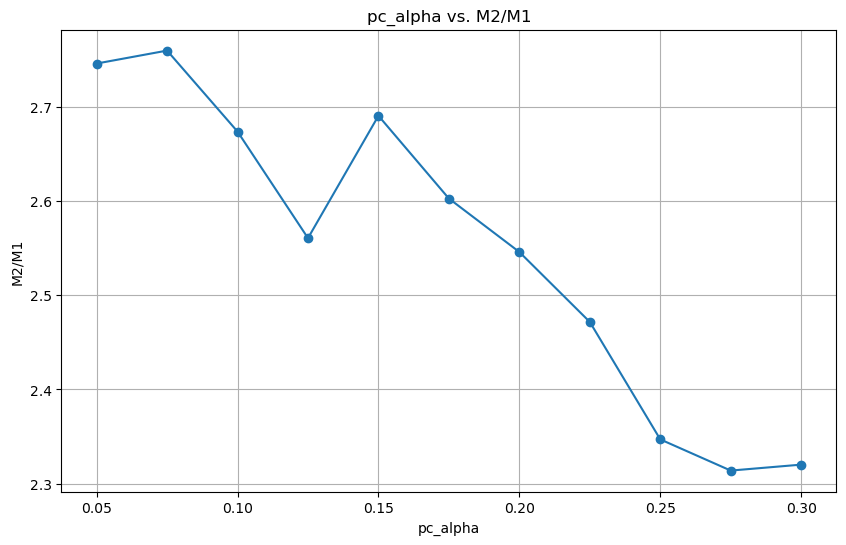

In [34]:
# x- und y-Werte aus dem DataFrame extrahieren
x = df2['pc_alpha']
y = df2['M2/M1']

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('pc_alpha')
plt.ylabel('M2/M1')
plt.title('pc_alpha vs. M2/M1')
plt.grid(True)

# Plot als PDF speichern
plt.savefig('./BilderBA/df2Plot.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

In [35]:
plot3={}
for element in temp:
    plot3[element[0][2]]=(0,0,0)



In [36]:
for element in temp:
    ncomp=element[0][0]
    pcalpha=element[0][1]
    mcialpha=element[0][2]
    m2divm1=round(element[1][1], 5)
    if pcalpha < 0.05:
        continue
    if plot3[mcialpha][2]<=m2divm1:
        plot3[mcialpha]=(ncomp, pcalpha, m2divm1)

In [37]:
del plot3[1e-06]
plot3

{0.01: (75, 0.1, 2.35311),
 0.0001: (100, 0.05, 2.74587),
 7e-07: (15, 0.275, 1.00272),
 5e-08: (3, 0.125, 1.02982),
 0.005: (100, 0.175, 2.60257),
 3e-07: (5, 0.075, 0.82918),
 7e-05: (65, 0.075, 2.13423),
 1e-08: (3, 0.075, 0.95454),
 1e-05: (50, 0.1, 1.92128),
 1e-07: (3, 0.2, 1.35902),
 0.0005: (100, 0.1, 2.67363),
 0.001: (100, 0.075, 2.75961),
 0.1: (15, 0.05, 1.05699),
 7e-06: (75, 0.05, 2.36379),
 3e-05: (65, 0.05, 2.33773)}

In [38]:
# Pandas DataFrame erstellen
temp3=[]
for key in plot3:
    value=plot3[key]
    temp3.append((key, str(int(value[0])), value[1], value[2]))
df3 = pd.DataFrame(temp3, columns=['mci_alpha', 'number components', 'pc_alpha', 'M2/M1'])
df3 = df3.sort_values(by='mci_alpha')
# DataFrame als PDF ohne Zeilennummern speichern
plt.figure(figsize=(10, 8))
plt.table(cellText=df3.values,
          colLabels=df3.columns,
          loc='center')
plt.axis('off')  # Achsen ausschalten
plt.savefig('./BilderBA/df3.pdf', bbox_inches='tight', pad_inches=0.05)
plt.close()
print(df3)

       mci_alpha number components  pc_alpha    M2/M1
7   1.000000e-08                 3     0.075  0.95454
3   5.000000e-08                 3     0.125  1.02982
9   1.000000e-07                 3     0.200  1.35902
5   3.000000e-07                 5     0.075  0.82918
2   7.000000e-07                15     0.275  1.00272
13  7.000000e-06                75     0.050  2.36379
8   1.000000e-05                50     0.100  1.92128
14  3.000000e-05                65     0.050  2.33773
6   7.000000e-05                65     0.075  2.13423
1   1.000000e-04               100     0.050  2.74587
10  5.000000e-04               100     0.100  2.67363
11  1.000000e-03               100     0.075  2.75961
4   5.000000e-03               100     0.175  2.60257
0   1.000000e-02                75     0.100  2.35311
12  1.000000e-01                15     0.050  1.05699


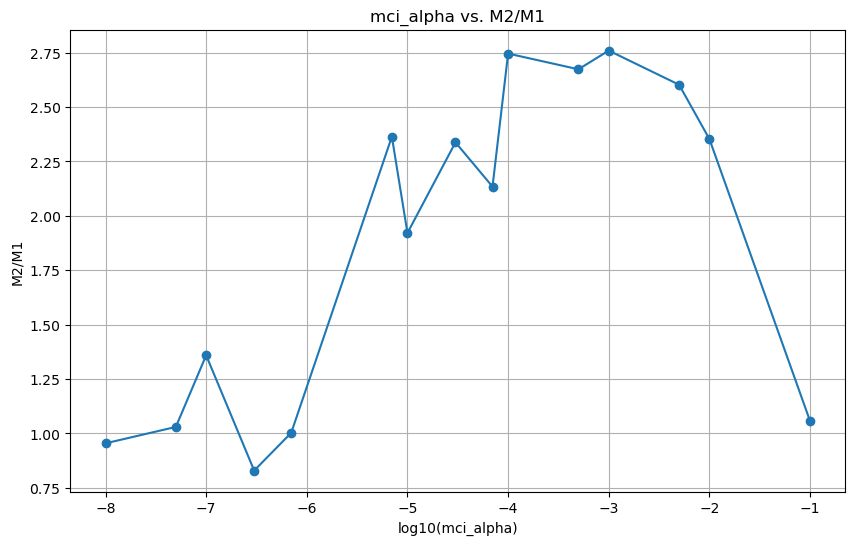

In [41]:
# DataFrame nach mci_alpha aufsteigend sortieren
df3_sorted = df3.sort_values(by='mci_alpha')

# Logarithmus zur Basis 10 auf die mci_alpha-Werte anwenden
df3_sorted['mci_alpha_log'] = np.log10(df3_sorted['mci_alpha'])

# x- und y-Werte aus dem sortierten DataFrame extrahieren
x = df3_sorted['mci_alpha_log']
y = df3_sorted['M2/M1']

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('log10(mci_alpha)')
plt.ylabel('M2/M1')
plt.title('mci_alpha vs. M2/M1')
plt.grid(True)

# Plot als PDF speichern
plt.savefig('./BilderBA/df3Plot.pdf', bbox_inches='tight', pad_inches=0.05)
plt.show()

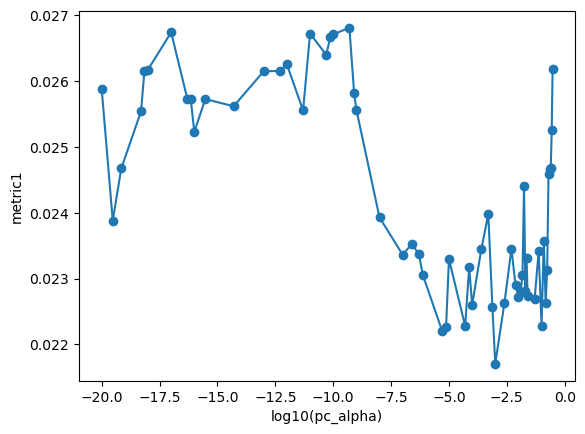

In [66]:
metric1_vs_pcAlpha = sorted(metric1_vs_pcAlpha, key=lambda x: x[0])

# Extrahiere die sortierten x- und y-Werte
x_values = [np.log10(entry[0]) for entry in metric1_vs_pcAlpha]
y_values = [entry[1] for entry in metric1_vs_pcAlpha]
# Plot
plt.plot(x_values, y_values, marker='o')
plt.xlabel('log10(pc_alpha)')
plt.ylabel('metric1')
plt.show()

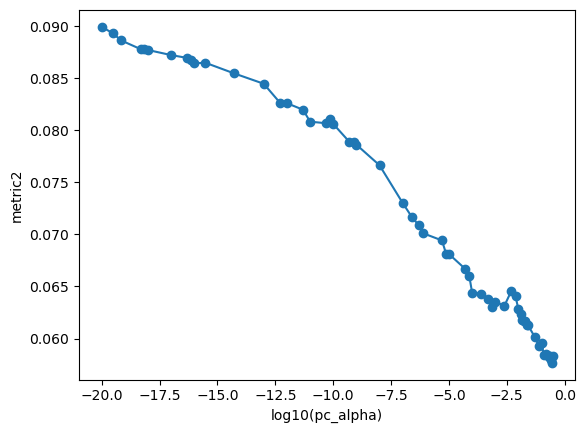

In [70]:
metric2_vs_pcAlpha = sorted(metric2_vs_pcAlpha, key=lambda x: x[0])

# Extrahiere die sortierten x- und y-Werte
x_values = [np.log10(entry[0]) for entry in metric2_vs_pcAlpha]
y_values = [entry[1] for entry in metric2_vs_pcAlpha]
# Plot
plt.plot(x_values, y_values, marker='o')
plt.xlabel('log10(pc_alpha)')
plt.ylabel('metric2')
plt.show()

In [ ]:
plt.plot(df_filtered_m1vscomps['Nr. components'], df_filtered_m1vscomps['Metric1'], marker='o', linestyle='-')
plt.xlabel('Nr. components')
plt.ylabel('Metric1')

title='Plot for Metric1 vs. Nr. components with pc_alpha = ' + str(filter_pcAlpha_pdDf) + ' and mci_alpha = ' + str(filter_mciAlpha_pdDf)
plt.title(title)
plt.grid(True)
plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()


In [ ]:
plt.plot(df_filtered_m1vspcalpha['pc_alpha'], df_filtered_m1vspcalpha['Metric1'], marker='o', linestyle='-')
plt.xlabel('pc_alpha')
plt.ylabel('Metric1')

title='Plot for Metric1 vs. pc_alpha with nr. components = ' + str(filter_nrComponents_pdDf) + ' and mci_alpha = ' + str(filter_mciAlpha_pdDf)
plt.title(title)
plt.grid(True)
plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()


In [ ]:
plt.plot(df_filtered_m1vsmcialpha['log10(mci_alpha)'], df_filtered_m1vsmcialpha['Metric1'], marker='o', linestyle='-')
plt.xlabel('log10(mci_alpha)')
plt.ylabel('Metric1')

title='Plot for Metric1 vs. mci_alpha with nr. components = ' + str(filter_nrComponents_pdDf) + ' and pc_alpha = ' + str(filter_pcAlpha_pdDf)
plt.title(title)
plt.grid(True)
plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()


In [ ]:
plt.plot(df3_filtered_m2vsnrcomponents['Nr. components'], df3_filtered_m2vsnrcomponents['Metric2'], marker='o', linestyle='-')
plt.xlabel('Nr. components')
plt.ylabel('Metric2')

title='Plot for Metric2 vs. nr. components with pc_alpha = ' + str(filter_pcAlpha_pdDf) + ' and pc_alpha = ' + str(filter_mciAlpha_pdDf)
plt.title(title)
plt.grid(True)
plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()


In [ ]:
plt.plot(df3_filtered_m2vspcalpha['pc_alpha'], df3_filtered_m2vspcalpha['Metric2'], marker='o', linestyle='-')
plt.xlabel('pc_alpha')
plt.ylabel('Metric2')

title='Plot for Metric2 vs. pc_alpha with nr. components = ' + str(filter_nrComponents_pdDf) + ' and mci_alpha = ' + str(filter_mciAlpha_pdDf)
plt.title(title)
plt.grid(True)
plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()


In [ ]:
plt.plot(np.log10(df3_filtered_m2vsmcialpha['mci_alpha']), df3_filtered_m2vsmcialpha['Metric2'], marker='o', linestyle='-')
plt.xlabel('log10(mci_alpha)')
plt.ylabel('Metric2')

title='Plot for Metric2 vs. mci_alpha with nr. components = ' + str(filter_nrComponents_pdDf) + ' and pc_alpha = ' + str(filter_pcAlpha_pdDf)
plt.title(title)
plt.grid(True)
plt.savefig('./images/gridSearch/' + title + '.pdf')
plt.show()


In [ ]:
keys=list(metric2_div_metric1.keys())
pc_alpha_values, comps = zip(*keys)
comps=list(set(comps))
pc_alpha_values=list(set(pc_alpha_values))

subplots={}
for element in comps:
    subplots.setdefault(element, [])



def plot_metric2_div_metric1_(key):
    plotTitle='Nr. of components: ' + str(key[1]) + ', pc_alpha: ' + str(key[0])
    if os.path.isfile('./images/gridSearch/'+plotTitle+'.png'):
        return

    # Gleichmäßig verteilte x-Werte erstellen
    values=metric2_div_metric1[key]
    x_values, y_values = zip(*values)
    x_values=list(x_values)
    y_values=list(y_values)
    x_uniform = np.linspace(min(x_values), max(x_values), len(x_values))
    labels=x_values

    # Plot erstellen
    plt.plot(x_uniform, y_values, marker='o', linestyle='-')

    # Labels hinzufügen
    for i, txt in enumerate(labels):
        plt.annotate(txt, (x_uniform[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
        
    plt.title(plotTitle)
    plt.ylabel('F1-Score')
    plt.figtext(0, 0, 'The resulting F1-Scores for N components, specific pc_alpha (see title) and different alpha_values vizualized. The lables are the alpha_values for the resulting F1-Scores')

    plt.ylim(0, 3)

    plt.savefig('./images/gridSearch/'+plotTitle+'.png',dpi=600)
    subplots[key[1]].append('./images/gridSearch/'+plotTitle+'.png')
    plt.close()

    
    
for key in metric2_div_metric1.keys():
    plot_metric2_div_metric1_(key)
    
    
    


In [18]:
from collections import OrderedDict

sorted_dict = OrderedDict(sorted(metric2_div_metric1_maxs_2.items(), key=lambda item: item[1][1]))
#sorted_dict

In [25]:
#metric2_div_metric1_maxs_2

In [ ]:
subplots_=sorted(subplots.items())

In [ ]:
subplots=dict(subplots_)

In [ ]:
for key in subplots:
    num_cols = len(subplots[key])  # Anzahl der Spalten
    num_rows = 1

    # Erzeugen Sie eine leere Abbildung mit einem Grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(50, 50))  # Passen Sie die Größe an

    # Fügen Sie jedes Bild in die Abbildung ein
    for i, subplot in enumerate(subplots[key]):
        img = mpimg.imread(subplot)
        col = i  # Keine Notwendigkeit, row zu verwenden, da num_rows auf 1 gesetzt ist
        axes[col].imshow(img)
        axes[col].axis('off')  # Optional: Achsen ausschalten

    # Zeigen Sie die Abbildung an
    plt.savefig('./images/gridSearch/'+'allGraphs'+'.png',dpi=600)

    plt.show()


In [ ]:
for key in metric2_div_metric1.keys():
    if key[1] > 50:
        plot_metric2_div_metric1(key)


In [132]:
def scatter_plot_2_(data, model_nr, title, name, save_name, vmin, vmax, nr_intervals, label):
    size_s = 40
    nr_models = len(data[:, 0, 0, 0])
    average = 0
    n_ensembles = nr_intervals
    all_values = []  # Hier werden alle Werte gesammelt

    for i in range(0, nr_models):
        if name[i] in ['era', 'NCEP']:
            plt.scatter(np.ones((nr_intervals**2)) * i, data[model_nr, i, :, :].flatten(), color='red', s=size_s)
            if i == model_nr:
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
            else:
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
        else:
            plt.scatter(np.ones(4*4) * i, data[model_nr, i, :, :].flatten(), color='red', s=size_s)
            if i == model_nr:
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
            else:
                average += np.nanmean(data[model_nr, i, :, :], axis=(0, 1))
                plt.scatter(i, np.nanmean(data[model_nr, i, :, :], axis=(0, 1)), marker='x', color='k', linewidth=2, s=size_s)
        all_values.extend(data[model_nr, i, :, :].flatten())

    min_value = np.nanmin(all_values)
    max_value = np.nanmax(all_values)

    average /= (nr_models - 1)
    plt.plot(np.linspace(-0.5, nr_models + 1, 100) - 0.25, np.ones((100)) * average, color='gray', linestyle='--', linewidth=2)
    plt.xticks(np.arange(0, nr_models), name[:], rotation=90, size=12)
    plt.ylabel(label, size=16, fontweight='bold')
    plt.xlim(-0.5, nr_models - 0.5)
    plt.ylim(min_value-100, max_value+100)  # Hier setzen Sie die Grenzen der y-Achse entsprechend der minimalen und maximalen Werte
    plt.title('Reference: ' + model_names[model_nr], fontweight='bold', size=12)
    plt.savefig('./images/gridSearch/' + title + '.png', dpi=600)
    plt.show()
    plt.close()

In [ ]:
#(50, 0.01, 0.0005)
#(50, 0.001, 0.1)

(50, 0.01, 0.0005)
average 0.5697535186201665


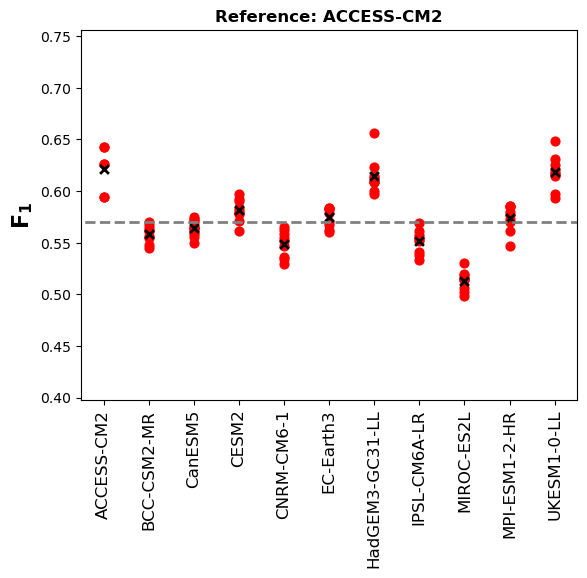

average 0.5415359147085744


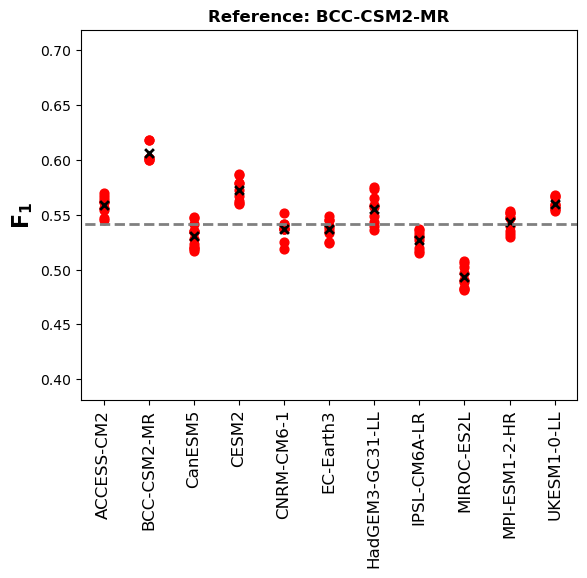

average 0.5497687886445968


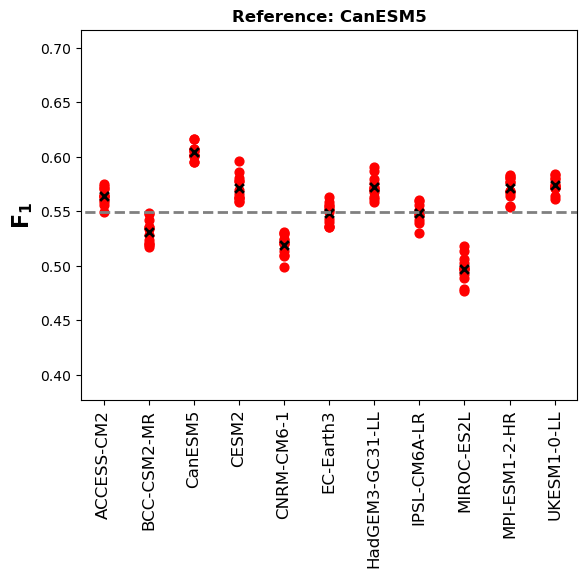

average 0.5638752521566788


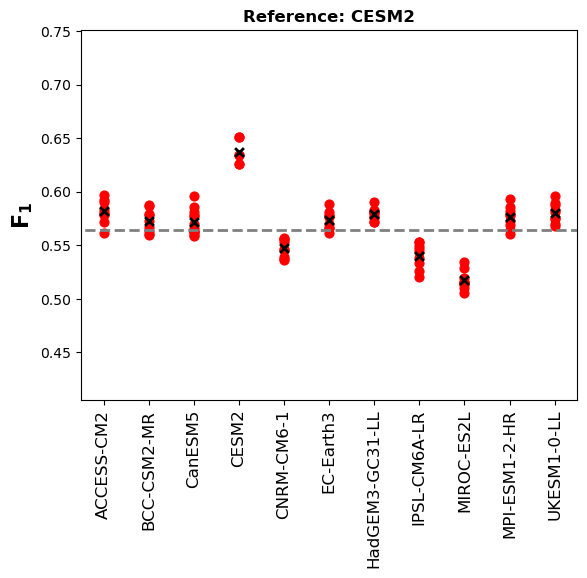

average 0.5503972487453467


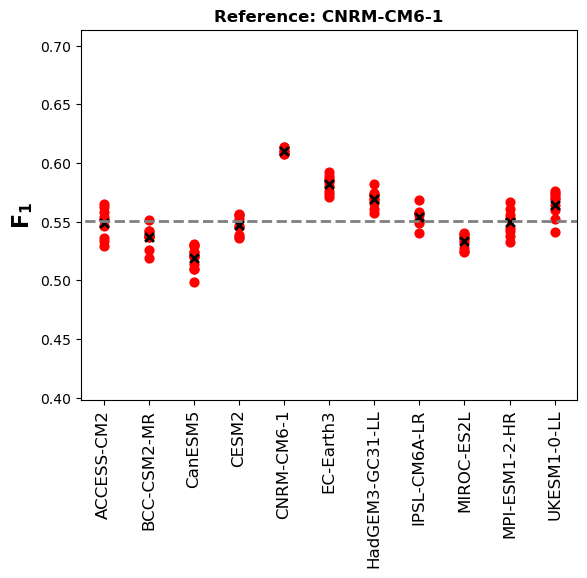

average 0.5692323060605053


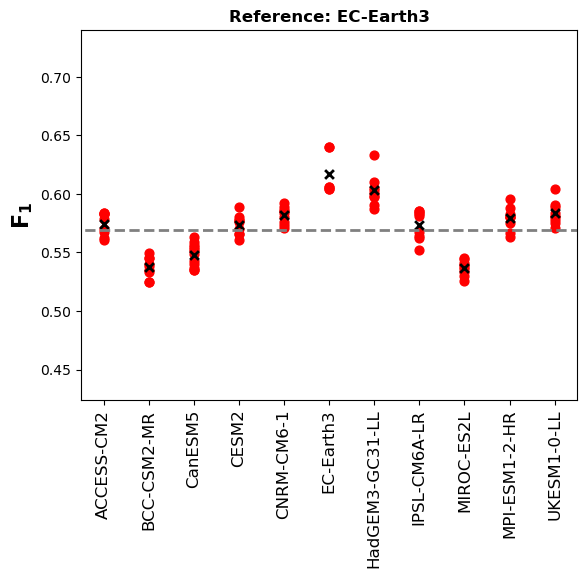

average 0.5811446654835749


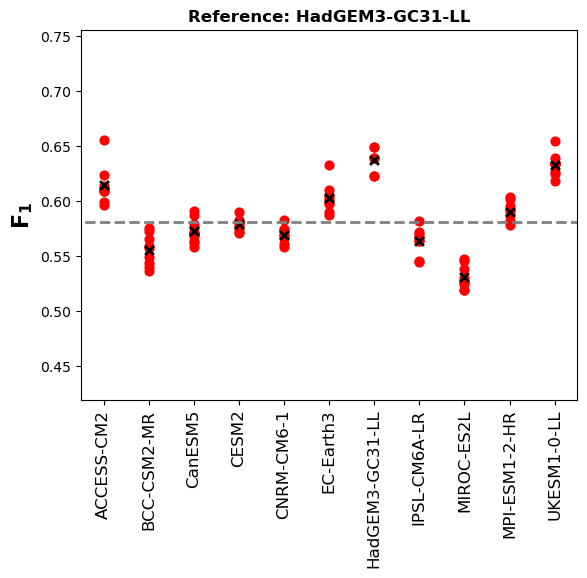

average 0.5506324713302981


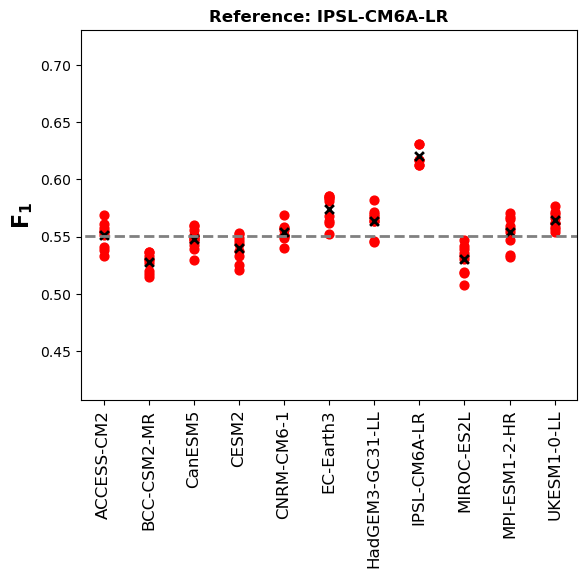

average 0.5206868200405795


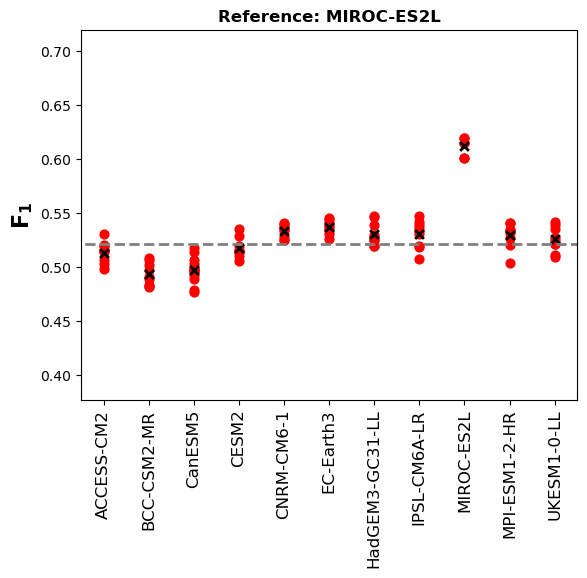

average 0.5646176911481008


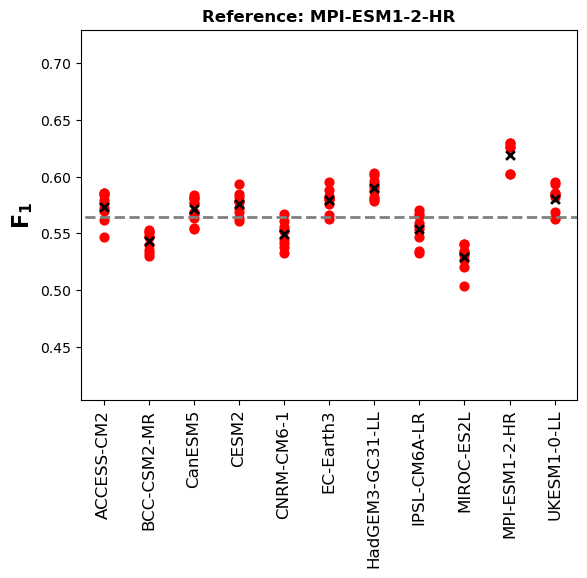

average 0.5783442847369255


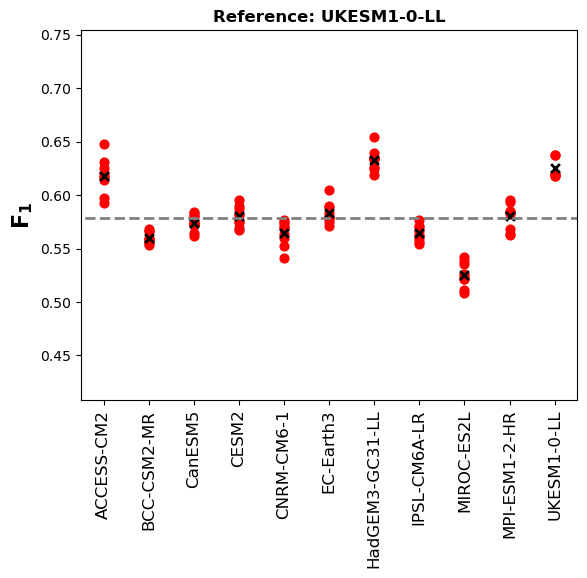

In [59]:
for key in sorted_dict_komps:
    if key[0]>=50:
        if key != (50, 0.01, 0.0005):
            continue
        print(key)
        for refModelIndex, model in enumerate(model_names):
            scatter_plot_2(f1Scores_[(key[1],key[0])][key[2]], refModelIndex, "comps: " + str(key[0]) + "|pc_alpha: " + str (key[1]) + "|alpha_value: " + str(key[2]), model_names, 'scatterplot2', 0.5, 1, 3, r'F$_{\mathbf{1}}$')

((0.05, 100), 1e-05)
average 0.515957755684236


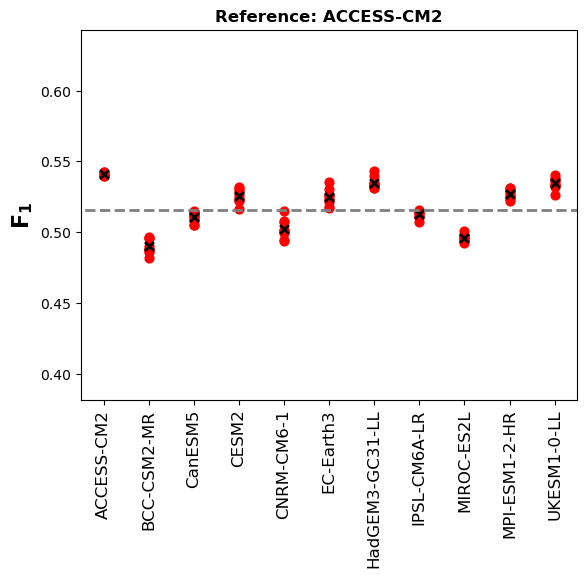

average 0.488766969476493


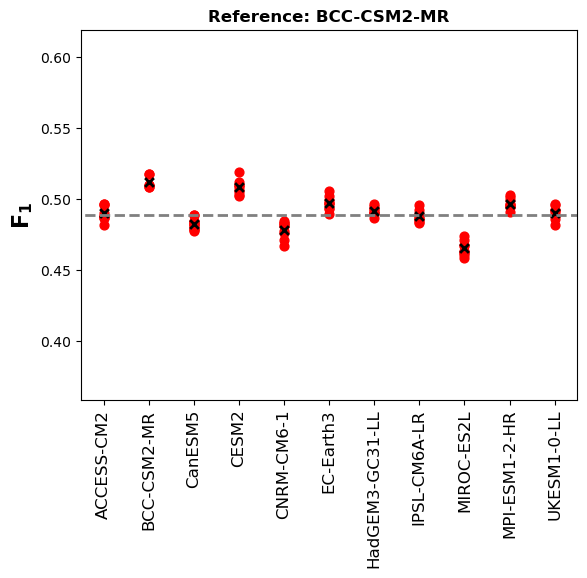

average 0.5054836448155592


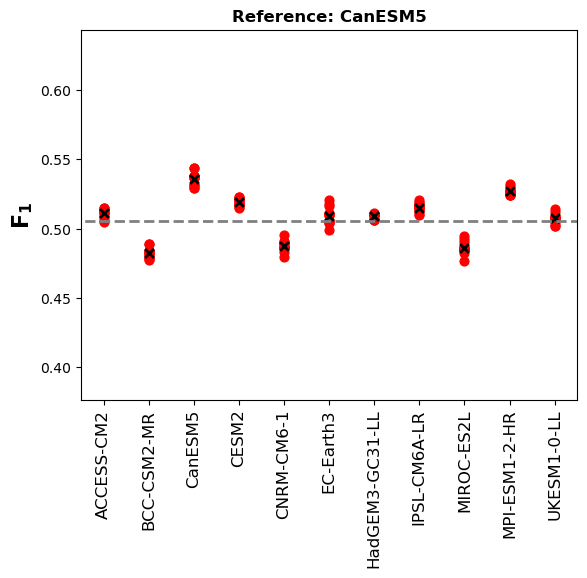

average 0.5196543867270138


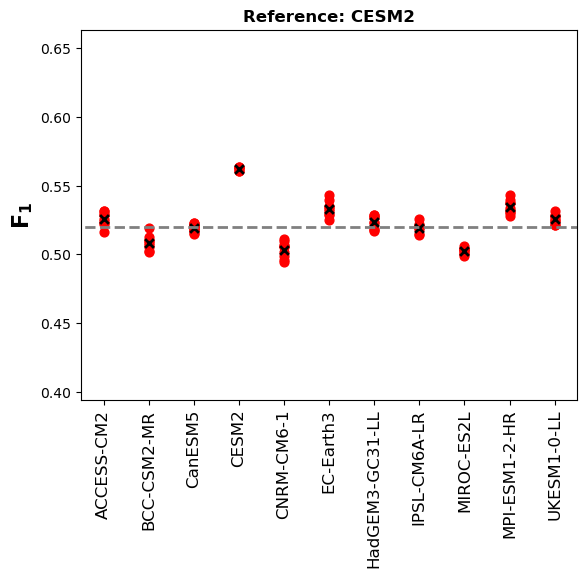

average 0.5033930683381354


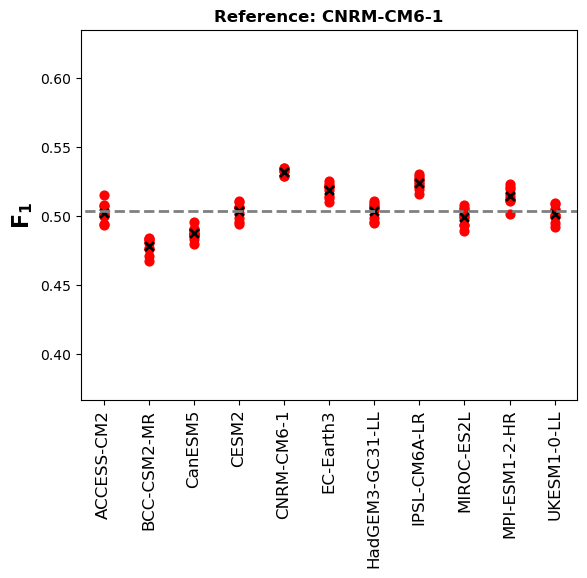

average 0.5219501418211638


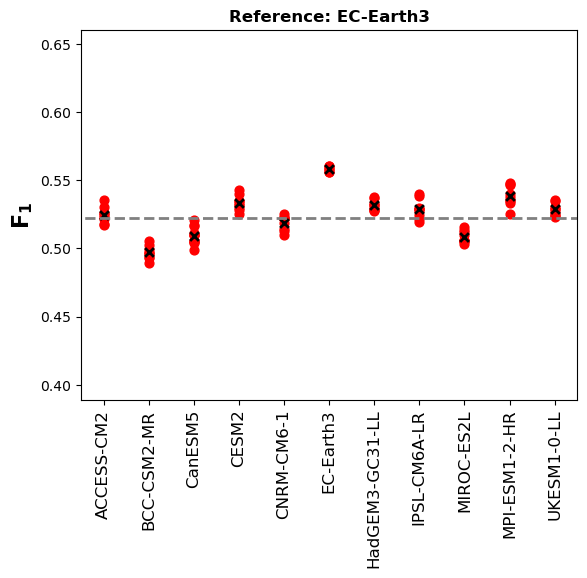

average 0.5171407390756397


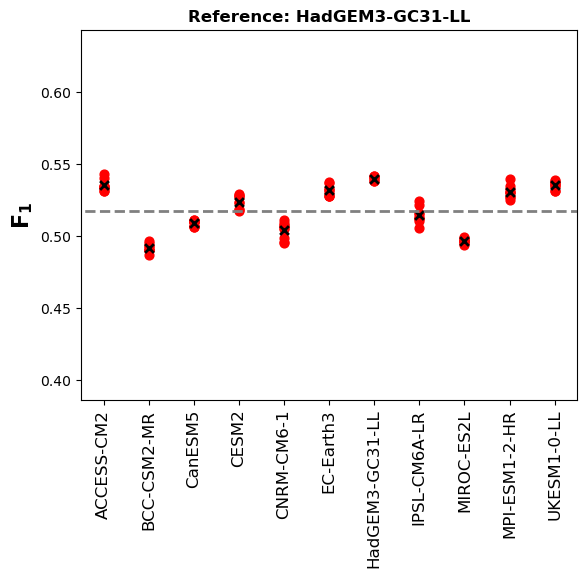

average 0.5161840237463257


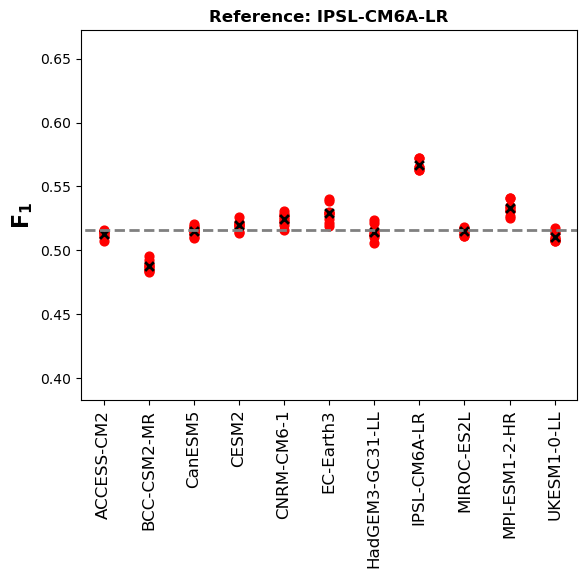

average 0.49745637200136017


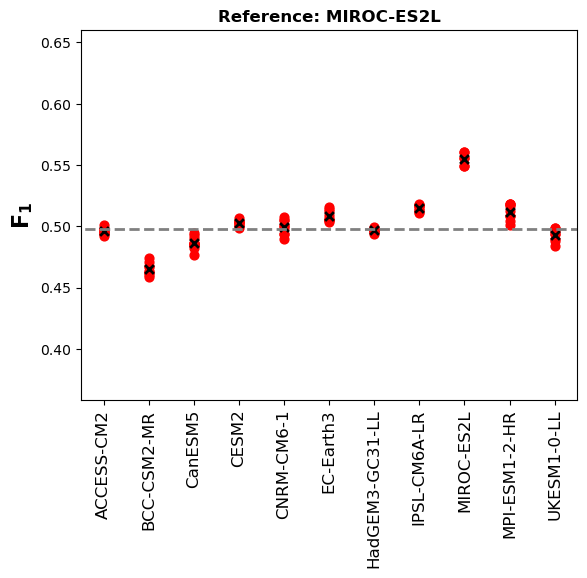

average 0.5242535729619846


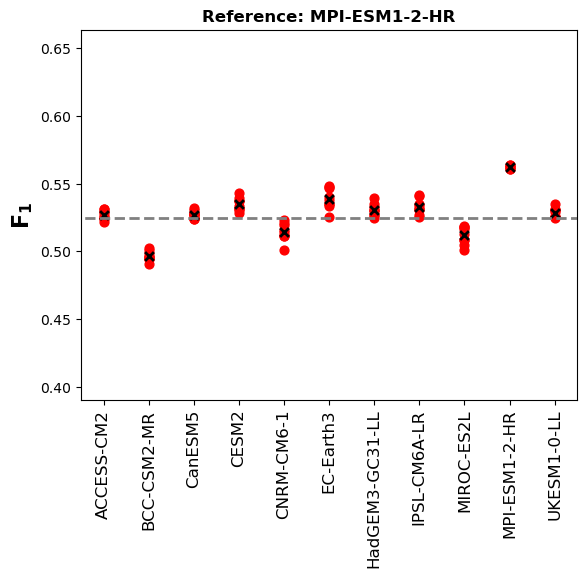

average 0.5155890563319303


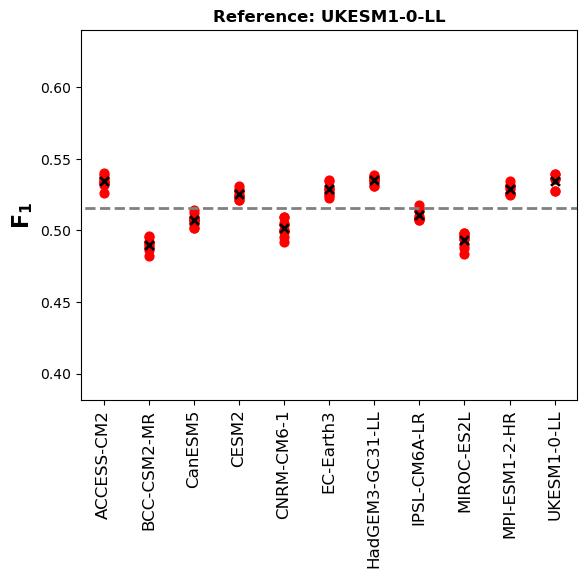

In [51]:
for key in m2_div_m1_o:
    if key[0][1]>=100:
        if key != ((0.05, 100), 1e-5): 
            continue
        print(key)
        for refModelIndex, model in enumerate(model_names):
            scatter_plot_2(f1Scores_[(key[0][0],key[0][1])][key[1]], refModelIndex, "comps: " + str(key[0]) + "|pc_alpha: " + str (key[1]) + "|alpha_value: " + str(key[1]), model_names, 'scatterplot2', 0.5, 1, 3, r'F$_{\mathbf{1}}$')

In [ ]:
def getMinMaxF1Score(key):
    mins=[]
    maxs=[]
    for key2 in f1Scores_[key]:
        mins.append(np.nanmin(f1Scores_[key][key2]))
        maxs.append(np.nanmax(f1Scores_[key][key2]))
    print(maxs)
    return (np.nanmin(mins), np.nanmax(maxs))
       

In [ ]:
getMinMaxF1Score((0.05,10))

In [ ]:
m2_div_m1_o.keys()

In [ ]:
sorted_dict_values = dict(sorted(sorted_dict_komps.items(), key=lambda x: x[1]))

In [ ]:
sorted_dict_values